Best one so far keeps the form correctly on single and multichannels. Only slight problem with making rounded figures as in filtered data.
Equilibrium is found after 10-20 epochs, but then the generator falls behind slightly every epoch, raising its loss by around 0.5 per 100 epochs.

used parameters:

dataset: (Comp2, True, True)

BATCH_SIZE = 128

latent_dim = 320

d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.2),

g_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.2),

Generator direct reshape!

In [188]:
from scipy.io import loadmat
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatreader import read_mat
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import eeg_funcs

In [189]:
filepath = glob('data/train/*.mat')
d_array, d_labels = eeg_funcs.get_comp2_array(filepath, True, True)
print(d_array.shape)

Creating RawArray with float64 data, n_channels=65, n_times=26328
    Range : 0 ... 26327 =      0.000 ...   109.696 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 0.10, 20.00 Hz: -6.02, -6.02 dB

540 events found
Event IDs: [1 2]
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 540 events and 160 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=65, n_times=26328
    Range : 0 ... 26327 =      0.000 ...   109.696 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will n

In [190]:
d_array = d_array*1e6
print(np.min(d_array), np.max(d_array))

-9327.168062535351 4688.771408840032


In [191]:
def normalize_data(data):
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    result = 2 * data - 1
    return result

In [192]:
print(d_array[2875,:,5])
d_array = normalize_data(d_array)
print(d_array[2875,:,5])

[ 799.52398626  686.48032515  565.8778192   452.42883376  356.88738528
  284.16558453  232.86443336  196.31934204  164.88629641  128.87561938
   81.36697688   20.16634141  -51.60669277 -126.441743   -194.59669374
 -246.87631829 -277.23988598 -284.49351426 -272.58053108 -249.38365625
 -224.38638525 -205.88429182 -198.58702818 -202.35616457 -212.4995337
 -221.57575736 -222.18803323 -209.90954513 -185.39551293 -154.93930687
 -129.17482508 -120.18967994 -137.82671086 -186.25547748 -261.8876477
 -353.37724825 -443.87239355 -515.02908927 -551.75127803 -546.35167275
 -500.92740921 -427.19966199 -343.75745218 -271.37895323 -227.66620555
 -222.45365922 -255.26573674 -315.55058472 -385.65861069 -445.77799436
 -479.49624428 -478.47653694 -444.9674954  -391.44037984 -337.41192686
 -304.26026625 -309.37819472 -361.1926221  -456.36352309 -579.91654985
 -708.30685899 -814.65672622 -874.85594205 -873.00825526 -804.90120092
 -678.71234907 -512.89005216 -331.85874823 -160.70452323  -20.16814377
   76.91

(12600, 160, 8) (12600,)
0


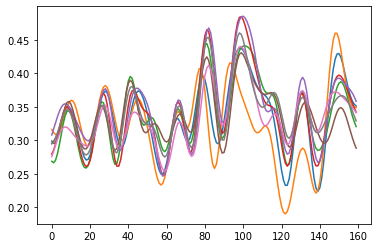

In [220]:
print(d_array.shape, d_labels.shape)
print(d_labels[2875])
plt.plot(d_array[2175,:,:])

In [194]:
#t_array = np.expand_dims(d_array, axis=3)
#data_array = t_array
#data_array = tf.convert_to_tensor(data_array, dtype=tf.float32)
data_array = tf.convert_to_tensor(d_array, dtype=tf.float32)

In [195]:
BUFFER_SIZE = 30000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(data_array).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [196]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [197]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=data_array.shape[1:]),
        layers.Conv1D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Conv1D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 80, 64)            2112      
                                                                 
 batch_normalization_82 (Bat  (None, 80, 64)           256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 80, 64)            0         
                                                                 
 dropout_32 (Dropout)        (None, 80, 64)            0         
                                                                 
 conv1d_33 (Conv1D)          (None, 40, 128)           32896     
                                                                 
 batch_normalization_83 (Bat  (None, 40, 128)          512       
 chNormalization)                                    

In [198]:
latent_dim = 320

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        #layers.Dense(10*128, use_bias=False),
        #layers.BatchNormalization(),
        #layers.LeakyReLU(alpha=0.2),
        layers.Reshape((10, 32)),
        layers.Conv1DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1DTranspose(64, 4, strides=4, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1DTranspose(8, 4, strides=2, padding='same', use_bias=False, activation='tanh'),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 10, 32)            0         
                                                                 
 conv1d_transpose_71 (Conv1D  (None, 20, 128)          16384     
 Transpose)                                                      
                                                                 
 batch_normalization_84 (Bat  (None, 20, 128)          512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 20, 128)           0         
                                                                 
 conv1d_transpose_72 (Conv1D  (None, 80, 64)           32768     
 Transpose)                                                      
                                                         

In [217]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [200]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images.numpy()
        for i in range(self.num_img):
            img = generated_images[i]
            img2 = img[:,5]
            plt.plot(img2)
            plt.savefig("testimages/single/generated_img_%03d_%d.png" % (epoch, i))
            plt.clf()
            plt.plot(img)
            plt.savefig("testimages/full/generated_img_%03d_%d.png" % (epoch, i))
            plt.clf()
            ##img = keras.preprocessing.image.array_to_img(generated_images[i])
            ##img.save("generated_img_%03d_%d.png" % (epoch, i))

In [201]:
checkpoint_filepath = 'checkpointTMP/checkpoint.{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='g_loss',
    mode='min',
    save_best_only=True)

In [186]:
epochs = 3500  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.2),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.2),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim), model_checkpoint_callback]
)

Epoch 1/3500
99/99 [==============================] - 3s 11ms/step - d_loss: 0.3557 - g_loss: 1.9200
Epoch 2/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3509 - g_loss: 1.8875
Epoch 3/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3539 - g_loss: 1.8945
Epoch 4/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3513 - g_loss: 1.9148
Epoch 5/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3522 - g_loss: 1.9369
Epoch 6/3500
99/99 [==============================] - 1s 9ms/step - d_loss: 0.3504 - g_loss: 1.8980
Epoch 7/3500
99/99 [==============================] - 1s 9ms/step - d_loss: 0.3534 - g_loss: 1.9162
Epoch 8/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3511 - g_loss: 1.9028
Epoch 9/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3476 - g_loss: 1.9244
Epoch 10/3500
99/99 [==============================] - 1s 10ms/step - d_loss: 0.3499 - g_loss

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>